In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
# Disable torch compile for Windows compatibility
import torch._dynamo
torch._dynamo.config.disable = True

from datetime import datetime, timezone
import logging
import copy

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from core_data_prep.core_data_prep import DataPreparer
from core_data_prep.validations import Validator

from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
from modeling.modeling_utils import print_model_parameters

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.actors.allocation_propogation_actor import AllocationPropogationActor
from modeling.rl.actors.market_actor import MarketActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss, ReinforceLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
str(config.data_config.frequency)

'1Day'

In [3]:
retriever = config.data_config.retriever
initial_state = config.model_config.model.state_dict()

In [4]:
def evaluate_signal_predictor(symbols: list[str], end_date: datetime, train_set_last_date: datetime, val_set_last_date: datetime, model=None):
    print(f'Running experiment for {config.data_config.start} to {end_date} with train set last date {train_set_last_date} and val set last date {val_set_last_date}')
    
    retrieval_result = retriever.bars_with_quotes(symbol_or_symbols=symbols, start=config.data_config.start, end=end_date)

    data_preparer = DataPreparer(
        normalizer=config.data_config.normalizer,
        missing_values_handler=config.data_config.missing_values_handler_polars,
        in_seq_len=config.data_config.in_seq_len,
        frequency=str(config.data_config.frequency),
        validator=config.data_config.validator,
    )

    (X_train, y_train, statistics_train), (X_val, y_val, statistics_val), (X_test, y_test, statistics_test) = \
        data_preparer.get_experiment_data(
            data=retrieval_result,
            start_date=None,
            end_date=None,
            features=config.data_config.features_polars,
            statistics=config.data_config.statistics,
            target=config.data_config.target,
            train_set_last_date=train_set_last_date,
            val_set_last_date=val_set_last_date,
        )
    next_return_train, spread_train, volatility_train, \
        next_return_val, spread_val, volatility_val, \
        next_return_test, spread_test, volatility_test = \
            statistics_train['next_return'], statistics_train['spread'], statistics_train['volatility'], \
            statistics_val['next_return'], statistics_val['spread'], statistics_val['volatility'], \
            statistics_test['next_return'], statistics_test['spread'], statistics_test['volatility']
        
    print(X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, X_test.shape,\
         y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape)

    if not model: 
        print('Training model...')
        train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )
        val_loader = DatasetPytorch(X_val, y_val, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )

        model = config.model_config.model
        model.load_state_dict(initial_state)

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_fn=config.train_config.loss_fn,
            optimizer=config.train_config.optimizer,
            scheduler=config.train_config.scheduler,
            num_epochs=config.train_config.num_epochs,
            early_stopping_patience=config.train_config.early_stopping_patience,
            device=config.train_config.device,
            metrics=config.train_config.metrics,
            save_path=config.train_config.save_path
        )

        model, history = trainer.train()
    else: 
        print('Using existing model...')

    test_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, \
            trajectory_length=config.rl_config.trajectory_length, horizon=config.data_config.horizon).as_dataloader(
        batch_size=1, 
        shuffle=False,
        num_workers=8,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        drop_last=False,
    )

    env = PortfolioEnvironment(
        reward_function=EstimatedReturnReward(fee=config.rl_config.fee, spread_multiplier=config.rl_config.spread_multiplier),
    )

    actor = RlActor(
        copy.deepcopy(model), 
        n_assets=len(config.data_config.symbol_or_symbols),
        train_signal_predictor=False, 
    ).to(device)

    # signal_predictor_actor = SignalPredictorActor(
    #     copy.deepcopy(model), 
    #     trade_asset_count=config.rl_config.trade_asset_count,
    #     train_signal_predictor=False
    # ).to(device)

    eval_actor = AllocationPropogationActor(
        copy.deepcopy(model), 
        train_allocator=False
    ).to(device)

    # eval_actor = MarketActor().to(device)

    rl_agent = RlAgent(
        actor, 
        env
    )

    metrics_calculator = MetricsCalculator(
        metrics=DEFAULT_METRICS
    )

    policy_gradient = PolicyGradient(
        rl_agent, 
        None, 
        test_trajectory_loader, 
        metrics_calculator=metrics_calculator,
        optimizer=torch.optim.AdamW(
            [p for p in actor.parameters() if p.requires_grad], 
            lr=1e-3,
            weight_decay=1e-5,
            amsgrad=True),
        scheduler=None,
        loss_fn=ReinforceLoss(use_baseline=False),
        num_epochs=10,
        device=device
    )

    epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(eval_actor, test_trajectory_loader)
    return actions_signal_predictor, realized_returns_signal_predictor, model, min(history['val_loss'])


In [ ]:

start_end_last_train_dates = [
    {'symbols': Constants.Data.NASDAQ_100, 'end': datetime(2021, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2020, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2019, 1, 1, tzinfo=timezone.utc)},
    {'symbols': Constants.Data.NASDAQ_100, 'end': datetime(2022, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2021, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2020, 1, 1, tzinfo=timezone.utc)},
    {'symbols': Constants.Data.NASDAQ_100, 'end': datetime(2023, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2022, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2021, 1, 1, tzinfo=timezone.utc)},
    {'symbols': Constants.Data.NASDAQ_100, 'end': datetime(2024, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2023, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2022, 1, 1, tzinfo=timezone.utc)},
    {'symbols': Constants.Data.NASDAQ_100, 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2024, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2023, 1, 1, tzinfo=timezone.utc)},
    {'symbols': Constants.Data.NASDAQ_100, 'end': datetime(2025, 11, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2024, 1, 1, tzinfo=timezone.utc)},
]

In [ ]:
realized_returns = []
actions = []
for i in range(len(start_end_last_train_dates)):
    best_model = None
    best_loss = 100.
    episode_returns = None
    for j in range(1): 
        cur_actions, cur_returns, cur_model, cur_val_loss = evaluate_signal_predictor(
            start_end_last_train_dates[i]['symbols'],
            start_end_last_train_dates[i]['end'], 
            start_end_last_train_dates[i]['last_train_date'], 
            start_end_last_train_dates[i]['last_val_date'], 
            best_model)
        if cur_val_loss < best_loss: 
            logging.info('Found better val loss, updating episode_returns')
            best_loss = cur_val_loss
            episode_returns = cur_returns
            episode_actions = cur_actions
    logging.info(f'Len of episode_returns: {len(episode_returns)}')
    realized_returns.extend(episode_returns)
    actions.extend(episode_actions)
    
    # for j in range(1): 
    #     cur_rezlized_returns, model = evaluate_signal_predictor(
    #         start_end_last_train_dates[i]['start'], 
    #         start_end_last_train_dates[i]['last_val_date'], 
    #         start_end_last_train_dates[i]['last_train_date'])
    #     if np.mean(cur_rezlized_returns) > best_mean_return:
    #         best_mean_return = np.mean(cur_rezlized_returns)
    #         best_model = model

    # realized_returns.extend(
    #     evaluate_signal_predictor(
    #         start_end_last_train_dates[i]['end'], 
    #         start_end_last_train_dates[i]['last_train_date'], 
    #         start_end_last_train_dates[i]['last_val_date'], 
    #         best_model)[0])

Running experiment for 1970-01-02 00:00:00-05:00 to 2010-01-01 00:00:00+00:00 with train set last date 2008-01-01 00:00:00+00:00 and val set last date 2009-01-01 00:00:00+00:00


2025-12-08 16:38:00,806 - WARNING - No data found for ek_us_d.csv in root folder
2025-12-08 16:38:00,947 - WARNING - No data found for GM between 1970-01-02 00:00:00-05:00 and 2010-01-01 00:00:00+00:00
2025-12-08 16:38:03,222 - INFO - retrieved 27 assets
2025-12-08 16:38:03,223 - INFO - Using monolithic slices with -60 timestamps
2025-12-08 16:38:03,871 - INFO - Found 9589 train slices, 336 val slices, 336 test slices
2025-12-08 16:38:03,872 - INFO - Trained per-asset targets


(13759, 27, 60, 16) (13759, 27) (13759, 27) (13759, 27) (13759, 27) (366, 27, 60, 16) (366, 27) (366, 27) (366, 27) (366, 27)
Training model...


2025-12-08 16:38:17,466 - INFO - Model compiled with torch.compile()
2025-12-08 16:38:17,467 - INFO - Epoch 1/20
2025-12-08 16:38:19,672 - INFO - Train Loss: -0.0090        
2025-12-08 16:38:19,673 - INFO - Train Log_return: -0.0133
2025-12-08 16:38:19,673 - INFO - Train Mean_return: 0.0148
2025-12-08 16:38:19,673 - INFO - Val   Loss: 0.0504
2025-12-08 16:38:19,674 - INFO - Val   Log_return: 0.0371
2025-12-08 16:38:19,674 - INFO - Val   Mean_return: -0.0314
2025-12-08 16:38:19,674 - INFO - New best model found! Updating best state dict.
2025-12-08 16:38:19,676 - INFO - 
2025-12-08 16:38:19,676 - INFO - Epoch 2/20
2025-12-08 16:38:20,536 - INFO - Train Loss: -0.0131       
2025-12-08 16:38:20,537 - INFO - Train Log_return: -0.0211
2025-12-08 16:38:20,537 - INFO - Train Mean_return: 0.0239
2025-12-08 16:38:20,538 - INFO - Val   Loss: 0.0427
2025-12-08 16:38:20,539 - INFO - Val   Log_return: 0.0334
2025-12-08 16:38:20,539 - INFO - Val   Mean_return: -0.0294
2025-12-08 16:38:20,539 - INFO 

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-12-08 16:38:37,492 - INFO - Found better val loss, updating episode_returns
2025-12-08 16:38:37,493 - INFO - Len of episode_returns: 13


Running experiment for 1970-01-02 00:00:00-05:00 to 2011-01-01 00:00:00+00:00 with train set last date 2009-01-01 00:00:00+00:00 and val set last date 2010-01-01 00:00:00+00:00


2025-12-08 16:38:38,369 - WARNING - No data found for ek_us_d.csv in root folder
2025-12-08 16:38:40,842 - INFO - retrieved 28 assets
2025-12-08 16:38:40,843 - INFO - Using monolithic slices with -60 timestamps
2025-12-08 16:38:41,507 - INFO - Found 9842 train slices, 336 val slices, 335 test slices
2025-12-08 16:38:41,508 - INFO - Trained per-asset targets


(14125, 28, 60, 16) (14125, 28) (14125, 28) (14125, 28) (14125, 28) (366, 28, 60, 16) (366, 28) (366, 28) (366, 28) (366, 28)
Training model...


2025-12-08 16:38:54,219 - INFO - Model compiled with torch.compile()
2025-12-08 16:38:54,220 - INFO - Epoch 1/20
2025-12-08 16:38:56,198 - INFO - Train Loss: -0.0058        
2025-12-08 16:38:56,199 - INFO - Train Log_return: -0.0093
2025-12-08 16:38:56,199 - INFO - Train Mean_return: 0.0105
2025-12-08 16:38:56,200 - INFO - Val   Loss: -0.0134
2025-12-08 16:38:56,200 - INFO - Val   Log_return: -0.0270
2025-12-08 16:38:56,200 - INFO - Val   Mean_return: 0.0319
2025-12-08 16:38:56,201 - INFO - New best model found! Updating best state dict.
2025-12-08 16:38:56,202 - INFO - 
2025-12-08 16:38:56,203 - INFO - Epoch 2/20
2025-12-08 16:38:57,119 - INFO - Train Loss: -0.0062        
2025-12-08 16:38:57,120 - INFO - Train Log_return: -0.0099
2025-12-08 16:38:57,120 - INFO - Train Mean_return: 0.0112
2025-12-08 16:38:57,120 - INFO - Val   Loss: -0.0127
2025-12-08 16:38:57,121 - INFO - Val   Log_return: -0.0262
2025-12-08 16:38:57,121 - INFO - Val   Mean_return: 0.0309
2025-12-08 16:38:57,121 - IN

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-12-08 16:39:06,339 - INFO - Found better val loss, updating episode_returns
2025-12-08 16:39:06,339 - INFO - Len of episode_returns: 13


Running experiment for 1970-01-02 00:00:00-05:00 to 2012-01-01 00:00:00+00:00 with train set last date 2010-01-01 00:00:00+00:00 and val set last date 2011-01-01 00:00:00+00:00


2025-12-08 16:39:07,223 - WARNING - No data found for ek_us_d.csv in root folder
2025-12-08 16:39:09,542 - INFO - retrieved 28 assets
2025-12-08 16:39:09,542 - INFO - Using monolithic slices with -60 timestamps
2025-12-08 16:39:10,435 - INFO - Found 10094 train slices, 335 val slices, 335 test slices
2025-12-08 16:39:10,436 - INFO - Trained per-asset targets


(14490, 28, 60, 16) (14490, 28) (14490, 28) (14490, 28) (14490, 28) (365, 28, 60, 16) (365, 28) (365, 28) (365, 28) (365, 28)
Training model...


2025-12-08 16:39:23,131 - INFO - Model compiled with torch.compile()
2025-12-08 16:39:23,132 - INFO - Epoch 1/20
2025-12-08 16:39:24,897 - INFO - Train Loss: -0.0059        
2025-12-08 16:39:24,898 - INFO - Train Log_return: -0.0096
2025-12-08 16:39:24,898 - INFO - Train Mean_return: 0.0110
2025-12-08 16:39:24,898 - INFO - Val   Loss: -0.0042
2025-12-08 16:39:24,899 - INFO - Val   Log_return: -0.0073
2025-12-08 16:39:24,899 - INFO - Val   Mean_return: 0.0084
2025-12-08 16:39:24,899 - INFO - New best model found! Updating best state dict.
2025-12-08 16:39:24,901 - INFO - 
2025-12-08 16:39:24,901 - INFO - Epoch 2/20
2025-12-08 16:39:25,859 - INFO - Train Loss: -0.0064        
2025-12-08 16:39:25,860 - INFO - Train Log_return: -0.0103
2025-12-08 16:39:25,860 - INFO - Train Mean_return: 0.0116
2025-12-08 16:39:25,860 - INFO - Val   Loss: -0.0075
2025-12-08 16:39:25,861 - INFO - Val   Log_return: -0.0105
2025-12-08 16:39:25,861 - INFO - Val   Mean_return: 0.0115
2025-12-08 16:39:25,861 - IN

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-12-08 16:39:36,271 - INFO - Found better val loss, updating episode_returns
2025-12-08 16:39:36,272 - INFO - Len of episode_returns: 13


Running experiment for 1970-01-02 00:00:00-05:00 to 2013-01-01 00:00:00+00:00 with train set last date 2011-01-01 00:00:00+00:00 and val set last date 2012-01-01 00:00:00+00:00


2025-12-08 16:39:37,148 - WARNING - No data found for ek_us_d.csv in root folder
2025-12-08 16:39:39,601 - INFO - retrieved 28 assets
2025-12-08 16:39:39,602 - INFO - Using monolithic slices with -60 timestamps
2025-12-08 16:39:40,295 - INFO - Found 10346 train slices, 335 val slices, 332 test slices
2025-12-08 16:39:40,296 - INFO - Trained per-asset targets


(14855, 28, 60, 16) (14855, 28) (14855, 28) (14855, 28) (14855, 28) (364, 28, 60, 16) (364, 28) (364, 28) (364, 28) (364, 28)
Training model...


2025-12-08 16:39:53,206 - INFO - Model compiled with torch.compile()
2025-12-08 16:39:53,207 - INFO - Epoch 1/20
2025-12-08 16:39:55,158 - INFO - Train Loss: -0.0059        
2025-12-08 16:39:55,158 - INFO - Train Log_return: -0.0097
2025-12-08 16:39:55,159 - INFO - Train Mean_return: 0.0110
2025-12-08 16:39:55,159 - INFO - Val   Loss: 0.0081
2025-12-08 16:39:55,159 - INFO - Val   Log_return: 0.0035
2025-12-08 16:39:55,160 - INFO - Val   Mean_return: -0.0019
2025-12-08 16:39:55,160 - INFO - New best model found! Updating best state dict.
2025-12-08 16:39:55,162 - INFO - 
2025-12-08 16:39:55,162 - INFO - Epoch 2/20
2025-12-08 16:39:56,197 - INFO - Train Loss: -0.0061        
2025-12-08 16:39:56,198 - INFO - Train Log_return: -0.0101
2025-12-08 16:39:56,198 - INFO - Train Mean_return: 0.0115
2025-12-08 16:39:56,198 - INFO - Val   Loss: 0.0078
2025-12-08 16:39:56,199 - INFO - Val   Log_return: 0.0033
2025-12-08 16:39:56,199 - INFO - Val   Mean_return: -0.0017
2025-12-08 16:39:56,199 - INFO

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-12-08 16:40:14,059 - INFO - Found better val loss, updating episode_returns
2025-12-08 16:40:14,060 - INFO - Len of episode_returns: 13


Running experiment for 1970-01-02 00:00:00-05:00 to 2014-01-01 00:00:00+00:00 with train set last date 2012-01-01 00:00:00+00:00 and val set last date 2013-01-01 00:00:00+00:00


2025-12-08 16:40:14,887 - WARNING - No data found for ek_us_d.csv in root folder
2025-12-08 16:40:17,115 - INFO - retrieved 28 assets
2025-12-08 16:40:17,116 - INFO - Using monolithic slices with -60 timestamps
2025-12-08 16:40:18,013 - INFO - Found 10598 train slices, 332 val slices, 333 test slices
2025-12-08 16:40:18,014 - INFO - Trained per-asset targets


(15219, 28, 60, 16) (15219, 28) (15219, 28) (15219, 28) (15219, 28) (365, 28, 60, 16) (365, 28) (365, 28) (365, 28) (365, 28)
Training model...


2025-12-08 16:40:29,166 - INFO - Model compiled with torch.compile()
2025-12-08 16:40:29,167 - INFO - Epoch 1/20
2025-12-08 16:40:31,116 - INFO - Train Loss: -0.0056        
2025-12-08 16:40:31,117 - INFO - Train Log_return: -0.0093
2025-12-08 16:40:31,117 - INFO - Train Mean_return: 0.0107
2025-12-08 16:40:31,117 - INFO - Val   Loss: -0.0040
2025-12-08 16:40:31,118 - INFO - Val   Log_return: -0.0053
2025-12-08 16:40:31,118 - INFO - Val   Mean_return: 0.0058
2025-12-08 16:40:31,118 - INFO - New best model found! Updating best state dict.
2025-12-08 16:40:31,120 - INFO - 
2025-12-08 16:40:31,120 - INFO - Epoch 2/20
2025-12-08 16:40:32,084 - INFO - Train Loss: -0.0064        
2025-12-08 16:40:32,085 - INFO - Train Log_return: -0.0102
2025-12-08 16:40:32,085 - INFO - Train Mean_return: 0.0115
2025-12-08 16:40:32,085 - INFO - Val   Loss: -0.0024
2025-12-08 16:40:32,086 - INFO - Val   Log_return: -0.0040
2025-12-08 16:40:32,086 - INFO - Val   Mean_return: 0.0046
2025-12-08 16:40:32,086 - IN

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-12-08 16:40:41,920 - INFO - Found better val loss, updating episode_returns
2025-12-08 16:40:41,921 - INFO - Len of episode_returns: 13


Running experiment for 1970-01-02 00:00:00-05:00 to 2015-01-01 00:00:00+00:00 with train set last date 2013-01-01 00:00:00+00:00 and val set last date 2014-01-01 00:00:00+00:00


2025-12-08 16:40:43,011 - WARNING - No data found for ek_us_d.csv in root folder
2025-12-08 16:40:45,759 - INFO - retrieved 28 assets
2025-12-08 16:40:45,760 - INFO - Using monolithic slices with -60 timestamps
2025-12-08 16:40:46,683 - INFO - Found 10848 train slices, 333 val slices, 336 test slices
2025-12-08 16:40:46,684 - INFO - Trained per-asset targets


In [ ]:
len(realized_returns)

In [ ]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns,
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end,
    compare_to_baseline=False
)

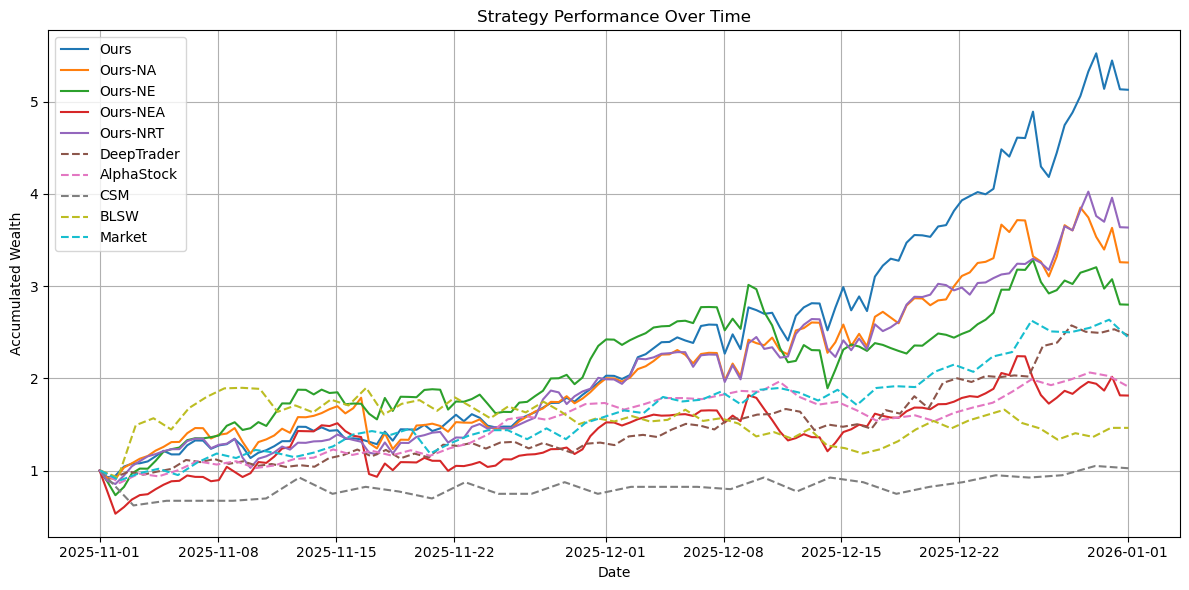

In [16]:
returns_dict = plot_cumulative_wealth(
    returns_dict={
        # 'Signal Predictor': realized_returns_signal_predictor
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end,
    ours_to_include=['Ours', 'Ours-NA', 'Ours-NE', 'Ours-NEA', 'Ours-NRT'],
    baseline_to_include=['DeepTrader', 'AlphaStock', 'CSM', 'BLSW', 'Market'],
    year_start=9
)

In [9]:
returns_dict.keys()

dict_keys(['ours-log-var', 'DeepTrader', 'AlphaStock', 'CSM', 'BLSW', 'Market'])

In [10]:
metrics = MetricsCalculator(
    metrics=DEFAULT_METRICS
)(returns_dict['ours-log-var'])
metrics

{'CumulativeReturn': 4.128888130187988,
 'MeanReturnPercentage': 1.39633659273386,
 'ARR': 4.128888130187988,
 'AVOL': 0.5887267446807869,
 'MDD': 15.37829041481018,
 'ASR': 7.0132504892855,
 'CR': 0.26848811010953666,
 'DDR': 10.61792489902203,
 'SoR': 0.40941932797431946}

In [ ]:
plot_position_heatmap(actions[-20:], asset_names=sorted(list(Constants.Data.DJIA_2000_2004[:-2])))

In [ ]:
pd.Series(realized_returns).to_csv('realized_returns_ours.csv')

In [ ]:
[sum(action) for action in actions]